# Part 1: data preparation

In [118]:
import os
import json

img_dir = '/scratch/lt2326-h21/a1/images/'
meta_file = '/scratch/lt2326-h21/a1/info.json'
annotation_file = '/scratch/lt2326-h21/a1/train.jsonl'

# open folder, loop through files, check if file in training set
with open(meta_file, "r") as json_file:
    meta = json.load(json_file)
    train_file_names = [obj['file_name'] for obj in meta['train']]
    files_to_keep = [img_path for img_path in os.listdir(img_dir) if img_path in train_file_names]

In [116]:
# split into training, validation, and test datasets
from sklearn.model_selection import train_test_split
training_data, temp_data = train_test_split(files_to_keep, test_size=0.3)
validation_data = temp_data[:len(temp_data)//2]
testing_data = temp_data[len(temp_data)//2:]

In [117]:
# find the corresponding bounding box information for each image
def get_bounding_boxes(files_list):
    with open(annotation_file, "r") as jsonl_file:
        result = {}
        for line in jsonl_file:
            line_as_dict = json.loads(line)
            if line_as_dict['file_name'] in files_list:
                for sentence in line_as_dict['annotations']:
                    for instance in sentence:
                        if instance['is_chinese']:
                            if line_as_dict['file_name'] not in result:
                                result[line_as_dict['file_name']] = []
                            result[line_as_dict['file_name']].append(instance['polygon'])
        return result
                            
training_dict = get_bounding_boxes(training_data)
validation_dict = get_bounding_boxes(validation_data)
testing_dict = get_bounding_boxes(testing_data)

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.path as mppath
from PIL import Image
import cv2
import numpy as np

grid = np.array([[[a,b] for b in list(range(2048))] for a in list(range(2048))])
grid = grid.reshape(2048*2048, 2)

In [6]:
# training data is tuple (img, pixel_labels)
# where img is of shape (2048, 2048, 3) (3 is rgb values of the pixel)
# pixel_labels is of shape (4194304,)
# meaning each pixel in img should have a label 1 or 0, corresponding if that pixel is inside the polygon

def get_pixel_labels(img_key, data_dict):
    # convert to numpy array
    img_array = mpimg.imread(img_dir + img_key)

    # if pixel is inside polygon, give it label true
    # if not, give label false
    final_labels = []
    for polygon in data_dict[img_key]:
        path = mppath.Path(np.array(polygon))
        pixel_labels = np.asarray(path.contains_points(grid), int)
        if len(final_labels) < 1:
            final_labels = pixel_labels
        else:
            final_labels = np.maximum(final_labels, pixel_labels) # replace old zeros with ones

    return (img_array, pixel_labels)

def parallel_processing(img_key, data_dict):
    return (get_pixel_labels(img_key, data_dict))

In [7]:
from joblib import Parallel, delayed
print("processing training data...")
train_data_list = Parallel(n_jobs=10)(delayed(parallel_processing)(img_key, training_dict) for img_key in list(training_dict.keys()))
print("processing validation data...")
validation_data_list = Parallel(n_jobs=10)(delayed(parallel_processing)(img_key, validation_dict) for img_key in list(validation_dict.keys()))
print("processing testing data...")
test_data_list = Parallel(n_jobs=10)(delayed(parallel_processing)(img_key, testing_dict) for img_key in list(testing_dict.keys()))

processing training data...
processing validation data...
processing testing data...


# Part 2: models

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [9]:
#(CONV => RELU => POOL) * 2 => FC => RELU => FC => SOFTMAX

class LeNetModel(nn.Module):
    def __init__(self):
        super(LeNetModel, self).__init__()
        # The number of channels in the input images is 1 for grayscale or 3 for RGB
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = (5,5))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=5)
        
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size = (5,5))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=3)
        
        # FC aka Fully Connected layer
        self.fc1 = nn.Linear(in_features=134*134*3, out_features=500)
        self.relu3 = nn.ReLU()
        
        self.fc2 = nn.Linear(in_features=500, out_features=2)
        self.sigmoid = nn.Sigmoid()
    # TODO The sigmoid function is used for the two-class logistic regression, whereas the softmax function is used for the multiclass logistic regression 
    
    def forward(self, data):
        # CONV => RELU => POOL
        data = self.conv1(data)
        data = self.relu1(data)
        data = self.maxpool1(data)
        
        # CONV => RELU => POOL
        data = self.conv2(data)
        data = self.relu2(data)
        data = self.maxpool2(data)

        # FC => RELU
        data = self.fc1(torch.flatten(data, 1))
        data = self.relu3(data)
        
        # FC => SOFTMAX
        data = self.fc2(data)
        output = self.sigmoid(data)
        return output

In [14]:
device = torch.device('cuda:1')

# training hyperparameters
batch_size = 4
learning_rate = 0.01
epochs = 3

# get DataLoader to get batches
train_data_loader = DataLoader(train_data_list, shuffle=True, batch_size=batch_size)

In [21]:
# initialize model, optimizer and loss function
leNetModel = LeNetModel().to(device)
optimizer = optim.Adam(leNetModel.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()

# train LeNet model
leNetModel.train()
for e in range(0, epochs):
    total_loss = 0
    for i, (input_data, labels) in enumerate(train_data_loader):
        input_data = input_data.reshape(len(input_data), 3, 2048, 2048).float()
        (input_data, labels) = (input_data.to(device), labels.to(device))
        output = leNetModel(input_data)

        # upsample the results
        m = nn.Upsample(size=2048*2048, mode="nearest")
        upsampled = m(output.reshape(len(input_data), 1, 2))
        
        # calculate loss
        loss = loss_fn(upsampled.reshape(len(input_data), 2048*2048), labels.float())
        total_loss += loss.item()
        print(total_loss/(i+1), end='\r') # print average loss for the epoch
        
        loss.backward() # compute gradients
        optimizer.step() # update parameters
        optimizer.zero_grad() # reset gradients
    print()

# save model
torch.save(leNetModel, "lenet_model.pt")

0.023836441942163417
0.020388533940186374
0.020403072640702535


In [105]:
#    A convolution block (Conv -> BN -> ReLU -> MaxPool)
#    ResLayer - 1
#    ResLayer - 2
#    ResLayer - 3
#    ResLayer - 4
#    A classifier block with average Pooling and a Linear Layer

# a residual block for ResNets under 50 layers
class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inplanes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # downsampling layer
        out += self.shortcut(x)
        
        out = self.relu(out)
        return out
    
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.in_planes = 3 # initial inplanes is the number of channels
        
        self.conv = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = (5,5))
        self.bn = nn.BatchNorm2d(num_features=3) # C from an expected input of size (N,C,H,W)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=5)
        
        # TODO ResLayers double the channels in each layer, num_blocks is 2 to implement ResNet18 architecture
        self.layer1 = self._make_layer(planes=3, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(planes=6, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(planes=12, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(planes=24, num_blocks=2, stride=2)
        
        # The resnet architecture has an adaptive average pooling layer at the end followed by a Linear layer
        # Softmax is included as part of the loss function. 
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(5, 5)) # TODO 
        self.fc = nn.Linear(in_features=600, out_features=250) # TODO change in_features (& out_features?)
        
    def forward(self, data):
        data = self.conv(data)
        data = self.bn(data)
        data = self.relu(data)
        data = self.maxpool(data)
        
        data = self.layer1(data)
        data = self.layer2(data)
        data = self.layer3(data)
        data = self.layer4(data)
        
        data = self.avgpool(data)
        data = torch.flatten(data, 1)
        data = self.fc(data)
        return data
    
    # TODO why are they called planes and not channels?
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1) # create a list of strides
        layers = []
        # Starting from 2nd resnet layers, only the first convolution layer of the first block has stride 2, the rest of all the convolution layers are of stride 1
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes # next input channels should be output channels
        return nn.Sequential(*layers)

In [106]:
resNetModel = ResNetModel().to(device)
optimizer2 = optim.Adam(resNetModel.parameters(), lr=learning_rate)
loss_fn2 = nn.BCELoss()

# train ResNet model
resNetModel.train()
for e in range(0, epochs):
    total_loss = 0
    for i, (input_data, labels) in enumerate(train_data_loader):
        input_data = input_data.reshape(len(input_data), 3, 2048, 2048).float()
        (input_data, labels) = (input_data.to(device), labels.to(device))
        output = resNetModel(input_data)
        
        # sigmoid + upsampling
        sigmoid = nn.Sigmoid()
        output = sigmoid(output)
        m = nn.Upsample(size=2048*2048, mode="nearest")
        upsampled = m(output.reshape(len(input_data), 1, 250))
        
        # calculate loss
        loss = loss_fn2(upsampled.reshape(len(input_data), 2048*2048), labels.float())
        total_loss += loss.item()
        print(total_loss/(i+1), end='\r') # print average loss for the epoch
        
        loss.backward() # compute gradients
        optimizer2.step() # update parameters
        optimizer2.zero_grad() # reset gradients
    print()
    
# save model
torch.save(resNetModel, "resnet_model.pt")

0.008555659892531495
0.0020329557517323196
0.0020473979608583693


# Part 3: testing and evaluation

In [107]:
# load models
leNetModel = torch.load("lenet_model.pt").to(device)
resNetModel = torch.load("resnet_model.pt").to(device)

In [24]:
validation_data_loader = DataLoader(validation_data_list, shuffle=True, batch_size=batch_size)
test_data_loader = DataLoader(test_data_list, shuffle=True, batch_size=batch_size)

In [108]:
def test(data_loader, model, output_features, do_sigmoid=False):
    mse = nn.MSELoss()
    test_loss = 0
    correct_guesses = 0

    model.eval()
    for i, (input_data, labels) in enumerate(data_loader):
        input_data = input_data.reshape(list(input_data.shape)[0], 3, 2048, 2048).float()
        (input_data, labels) = (input_data.to(device), labels.to(device))
        
        with torch.no_grad():
            output = model(input_data)
            
        if do_sigmoid:
            sigmoid = nn.Sigmoid()
            output = sigmoid(output)
            
        m = nn.Upsample(size=2048*2048, mode="nearest")
        upsampled = m(output.unsqueeze(0))
        
        loss = mse(upsampled.squeeze(), labels)
        test_loss += loss.item()
        
        correct_guesses += torch.sum(torch.eq(torch.argmax(upsampled, dim=1), labels))

    accuracy = int(correct_guesses) / ((i+1) * batch_size * 3*2048*2048)

    print('average MSE', np.round(test_loss/(i+1), 4))
    print('total MSE', test_loss)
    print('accuracy: ', accuracy)

In [109]:
# validation
test(validation_data_loader, leNetModel, 2)
test(validation_data_loader, resNetModel, 250, True)

average MSE 0.0005
total MSE 0.015172978244663682
accuracy:  0.3305712112536033
average MSE 0.0005
total MSE 0.01518008883249422
accuracy:  0.12783896550536156


In [110]:
# testing
test(test_data_loader, leNetModel, 2)
test(test_data_loader, resNetModel, 250)

average MSE 0.0001
total MSE 0.003672440849186387
accuracy:  0.3306911898156007
average MSE 125.2178
total MSE 4006.968276977539
accuracy:  0.0561422947794199


It should also be possible to examine the effects of applying the model to individual images.  Make it possible to visually represent the pixel/bounding box probabilities superimposed on the original images.  Examine some of the images to conduct a qualitative error analysis of your trained models.

In [95]:
%matplotlib inline

def visualise(model, img, gold, output_features, do_sigmoid=False):
    img_tensor = torch.tensor(img)
    img_tensor = img_tensor.reshape(3, 2048, 2048).unsqueeze(0).float().to(device)

    with torch.no_grad():
        output = model(img_tensor)
        
    if do_sigmoid:
            sigmoid = nn.Sigmoid()
            output = sigmoid(output)
            
    m = nn.Upsample(size=2048*2048, mode="nearest")
    upsampled = m(output.reshape(1,1,output_features))
    probabilities = upsampled.reshape(2048,2048).squeeze()
    arr = np.array(probabilities.cpu())
    
    plt.imshow(arr, cmap='gray')
    plt.figure()
    plt.imshow(gold.reshape(2048,2048), cmap='gray')
    plt.figure()
    imgplot = plt.imshow(img)

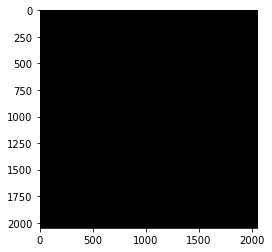

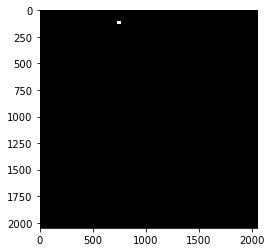

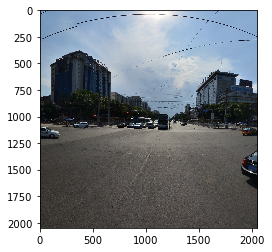

In [96]:
visualise(leNetModel, validation_data_list[117][0], validation_data_list[117][1], 2)

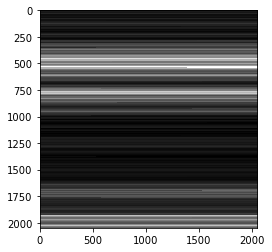

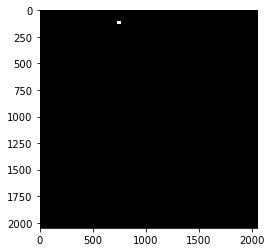

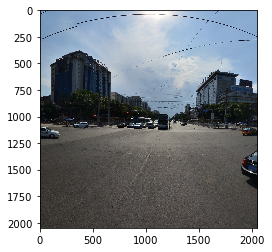

In [111]:
visualise(resNetModel, validation_data_list[117][0], validation_data_list[117][1], 250, True)

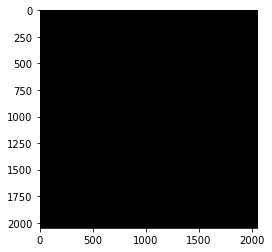

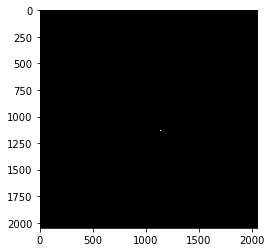

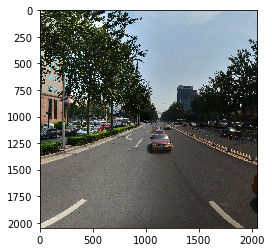

In [98]:
visualise(leNetModel, validation_data_list[45][0], validation_data_list[45][1], 2)

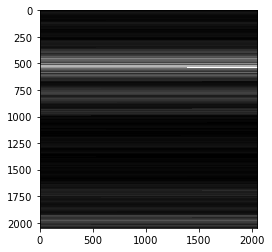

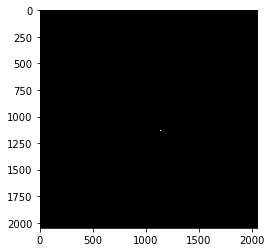

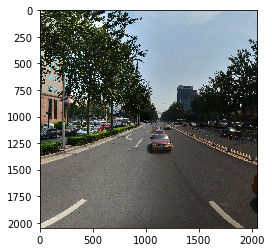

In [112]:
visualise(resNetModel, validation_data_list[45][0], validation_data_list[45][1], 250, True)